In [5]:
%load_ext autoreload
%autoreload 2


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import sys
import os
import time

from scipy.stats import t

#needed to import utils.py
sys.path.append('../') 

import utils
import utils_preprocessing
import utils_exec_models
import utils_exec_models_new

import numpy as np
import pandas as pd
#to view entire text of the comuns
pd.set_option('display.max_colwidth', None) 

import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import HTML

from IPython.display import clear_output

# Import module for data visualization
from plotnine import *
import plotnine

import pickle

%matplotlib inline  

In [39]:
df_best = utils.read_csv(csv_file='exec_results/best_results.csv')
display(df_best[[
    'Algorithm',
    'Scenario',
    'Features',
    'Model',
    'balanced_accuracy',
    'sensitivity',
    'specificity',
    'Model_Class',
    'Hyperparams',
    'Estimator_Class',
    'Estimator_Hyperparams',
]])

df_best.Algorithm.unique()

,Algorithm,Scenario,Features,Model,balanced_accuracy,sensitivity,specificity,Model_Class,Hyperparams,Estimator_Class,Estimator_Hyperparams
0,Decision Tree,Ensemble-Imbalance,All Features,Balanced Bagging,0.88,0.96,0.81,BalancedBaggingClassifier,"{'estimator':DecisionTreeClassifier(class_weight='balanced',max_depth=4,random_state=42),'n_estimators':7,'random_state':42,'replacement':True,'sampling_strategy':'all','warm_start':True}",DecisionTreeClassifier,"{'ccp_alpha':0.0,'class_weight':'balanced','criterion':'gini','max_depth':4,'max_features':None,'max_leaf_nodes':None,'min_impurity_decrease':0.0,'min_samples_leaf':1,'min_samples_split':2,'min_weight_fraction_leaf':0.0,'random_state':42,'splitter':'best'}"
1,Neural Networks,Ensemble-Imbalance,All Features,Balanced Bagging,0.88,0.96,0.80,BalancedBaggingClassifier,"{'estimator':MLPClassifier(activation='tanh',alpha=0.1,hidden_layer_sizes=30,learning_rate='adaptive',learning_rate_init=0.7,max_iter=2000,random_state=42),'n_estimators':101,'random_state':42,'replacement':True,'sampling_strategy':'auto','warm_start':False}",MLPClassifier,"{'activation':'tanh','alpha':0.1,'batch_size':'auto','beta_1':0.9,'beta_2':0.999,'early_stopping':False,'epsilon':1e-08,'hidden_layer_sizes':30,'learning_rate':'adaptive','learning_rate_init':0.7,'max_fun':15000,'max_iter':2000,'momentum':0.9,'n_iter_no_change':10,'nesterovs_momentum':True,'power_t':0.5,'random_state':42,'shuffle':True,'solver':'adam','tol':0.0001,'validation_fraction':0.1,'verbose':False,'warm_start':False}"
2,Random Forest,Ensemble-Imbalance,All Features,Balanced Random Forest,0.87,0.96,0.79,BalancedRandomForestClassifier,"{'criterion':'entropy','max_depth':7,'n_estimators':19,'random_state':42,'replacement':True,'sampling_strategy':'auto','warm_start':False}",RandomForest,NaN
3,SVM,Ensemble-Imbalance,All Features,Balanced Bagging,0.87,0.94,0.81,BalancedBaggingClassifier,"{'estimator':SVC(C=3,class_weight='balanced',gamma='auto',probability=True,random_state=42),'n_estimators':51,'random_state':42,'replacement':False,'sampling_strategy':'auto','warm_start':True}",SVC,"{'C':3,'break_ties':False,'cache_size':200,'class_weight':'balanced','coef0':0.0,'decision_function_shape':'ovr','degree':3,'gamma':'auto','kernel':'rbf','max_iter':-1,'probability':True,'random_state':42,'shrinking':True,'tol':0.001,'verbose':False}"
4,SVM,Single-Model,All Features,SVM,0.87,0.94,0.80,SVC,"{'C':0.3,'class_weight':'balanced','gamma':'auto','kernel':'rbf','probability':True,'random_state':42}",NaN,NaN
5,Random Forest,Single-Model,All Features,Random Forest,0.87,0.89,0.86,RandomForestClassifier,"{'class_weight':'balanced','criterion':'gini','max_depth':5,'n_estimators':51,'random_state':42}",NaN,NaN
6,Neural Networks,Single-Model,All Features,Neural Networks,0.87,0.87,0.87,MLPClassifier,"{'activation':'tanh','alpha':0.3,'hidden_layer_sizes':(23,23,23),'learning_rate':'constant','learning_rate_init':0.7,'max_iter':2000,'random_state':42,'solver':'sgd'}",NaN,NaN
7,k-NN,Ensemble-Imbalance,All Features,Balanced Bagging,0.85,0.85,0.85,BalancedBaggingClassifier,"{'estimator':KNeighborsClassifier(metric='euclidean',weights='distance'),'n_estimators':101,'random_state':42,'replacement':True,'sampling_strategy':'all','warm_start':True}",KNeighborsClassifier,"{'algorithm':'auto','leaf_size':30,'metric':'euclidean','metric_params':None,'n_jobs':None,'n_neighbors':5,'p':2,'weights':'distance'}"
8,Naïve Bayes,Ensemble-Imbalance,All Features,Balanced Bagging,0.84,0.85,0.83,BalancedBaggingClassifier,"{'estimator':GaussianNB(),'n_estimators':31,'random_state':42,'replacement':True,'sampling_strategy':'all','warm_start':False}",GaussianNB,"{'priors':None,'var_smoothing':1e-09}"
9,Decision Tree,Single-Model,All Features,Decision Tree,0.83,0.85,0.81,DecisionTreeClassifier,"{'class_weight':'balanced','criterion':'gini','max_depth':4,'random_state':42}",NaN,NaN


array(['Decision Tree', 'Neural Networks', 'Random Forest', 'SVM', 'k-NN',
       'Naïve Bayes'], dtype=object)

In [45]:
# get current folder
path = os.path.abspath('exec_results/serialized_data/')

# get the folders containg the results csv files
serialized_gridsearch_objects = []

algos = set()

for root, folders, files in os.walk(path, topdown=False):
    
    for name in files:

        if name.startswith('grid_search__') and '__All_Features__' in name:

            aux = name.replace('.pickle', '').split('__')[1:]
            
            # get scenario info
            algorithm = utils.get_model_description(aux[0]) 
            features = aux[1]
            scenario = aux[2].replace('_', '-') 
            balanced_classifier = ''
            
            if scenario == 'Ensemble_Imbalance':
               balanced_classifier = utils.get_model_description(aux[3])     

            # open pickle file
            file = open(os.path.join(root, name), 'rb')
            obj = pickle.load(file)
            
            serialized_gridsearch_objects.append(
                [algorithm, scenario, balanced_classifier, obj]
            )
            
            algos.add(algorithm)

            
# print(algos)

for item in serialized_gridsearch_objects:
    print(item[0], item[1])

# utils.print_array_as_list(serialized_gridsearch_objects)
            


Decision Tree Single-Model
Naïve Bayes Ensemble-Imbalance
Decision Tree Ensemble-Imbalance
Naïve Bayes Single-Model
k-NN Single-Model
Random Forest Ensemble-Imbalance
Random Forest Single-Model
Naïve Bayes Single-Model
Naïve Bayes Ensemble-Imbalance
Neural Networks Single-Model
k-NN Single-Model
k-NN Ensemble-Imbalance
Neural Networks Ensemble-Imbalance
SVM Single-Model
k-NN Ensemble-Imbalance
SVM Ensemble-Imbalance


In [62]:


for algorithm, scenario, balanced_classifier, grid in serialized_gridsearch_objects:
    
    print(algorithm, scenario)

    # find the best performance for the algorithm and scenario
    df_aux = df_best.loc[(
         (df_best.Algorithm == algorithm)
        &(df_best.Scenario  == scenario)
    )]
    
    display(df_aux)
    
    # get data from first row
    row = df_aux.iloc[0]

    best_param = row.Hyperparams
    
    idx_best_estimator = -1
    for idx, param in enumerate(grid.cv_results_['params']):
        param_str = str(param).replace(' ', '').replace('\n', '')
        if param_str == best_param:
            print(f'Idx: {idx}', param_str)
            print()
            idx_best_estimator = idx

            
    for item in grid.cv_results_:
        print(item, grid.cv_results_[item][idx_best_estimator])
            
            
    print(grid.cv_results_[:][idx_best_estimator])
    
    break

Decision Tree Single-Model


,Algorithm,Scenario,Features,Model,balanced_accuracy,sensitivity,specificity,f1_score,AUC,accuracy,...,Estimator_Class,Estimator_Hyperparams,fit_time,train_balanced_accuracy,train_sensitivity,train_specificity,train_f1_score,train_AUC,train_accuracy,train_precision
9,Decision Tree,Single-Model,All Features,Decision Tree,0.83,0.85,0.81,0.53,0.88,0.82,...,NaN,NaN,0.01,0.76,0.75,0.77,0.46,0.84,0.77,0.33


Idx: 17 {'class_weight':'balanced','criterion':'gini','max_depth':4,'random_state':42}

mean_fit_time 0.0027275562286376955
std_fit_time 0.00016412852739602145
mean_score_time 0.006513818105061849
std_score_time 0.0001684526381096384
param_class_weight balanced
param_criterion gini
param_max_depth 4
param_random_state 42
params {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'random_state': 42}
split0_test_balanced_accuracy 0.8014954602100766
split1_test_balanced_accuracy 0.7709631475876803
split2_test_balanced_accuracy 0.7032668684351078
split3_test_balanced_accuracy 0.8219890510948905
split4_test_balanced_accuracy 0.7496350364963503
split5_test_balanced_accuracy 0.7990920420153107
split6_test_balanced_accuracy 0.8033202777283247
split7_test_balanced_accuracy 0.7167082072280577
split8_test_balanced_accuracy 0.7738138686131386
split9_test_balanced_accuracy 0.7146897810218977
split10_test_balanced_accuracy 0.7020206515933773
split11_test_balanced_accuracy 0.76299626134

TypeError: unhashable type: 'slice'

<code>{'class_weight':'balanced','criterion':'gini','max_depth':4,'random_state':42}</code>

In [36]:
for item in grid.cv_results_:
    print(item, grid.cv_results_[item][17])


mean_fit_time 0.0027275562286376955
std_fit_time 0.00016412852739602145
mean_score_time 0.006513818105061849
std_score_time 0.0001684526381096384
param_class_weight balanced
param_criterion gini
param_max_depth 4
param_random_state 42
params {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'random_state': 42}
split0_test_balanced_accuracy 0.8014954602100766
split1_test_balanced_accuracy 0.7709631475876803
split2_test_balanced_accuracy 0.7032668684351078
split3_test_balanced_accuracy 0.8219890510948905
split4_test_balanced_accuracy 0.7496350364963503
split5_test_balanced_accuracy 0.7990920420153107
split6_test_balanced_accuracy 0.8033202777283247
split7_test_balanced_accuracy 0.7167082072280577
split8_test_balanced_accuracy 0.7738138686131386
split9_test_balanced_accuracy 0.7146897810218977
split10_test_balanced_accuracy 0.7020206515933773
split11_test_balanced_accuracy 0.7629962613494748
split12_test_balanced_accuracy 0.7728769805946235
split13_test_balanced_accuracy 0

/home/papaiz/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/papaiz/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

LR: 0.773445 (0.044035)
LDA: 0.766969 (0.047966)
KNN: 0.710988 (0.050792)
CART: 0.683732 (0.046416)
NB: 0.759142 (0.038960)
SVM: 0.760458 (0.034712)


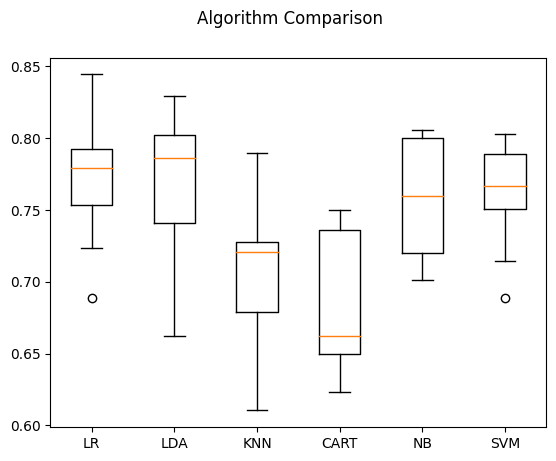

In [3]:
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
     kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)
     cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
     results.append(cv_results)
     names.append(name)
     msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
     print(msg)

    # boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()